<h1><center>CAN A COMPUTER RECOGNIZE SIGN LANGUAGE?</h1></center>

## Project Problem and Hypothesis

BACKGROUND:  Sign language is a language that uses hand motions to represent a word or concept.  Sign language is not easily understood by hearing people with no background in sign language.  If there were a way to translate sign language motions into English, this would greatly increase the ability of the hearing and hard-of-hearing to understand each other.

OBJECTIVE:  Can we use motion sensor data to translate signs in Australian sign language into written English?

HYPOTHESIS:  Given motion sensor data, a machine learning algorithm can identify the word "what" (classification problem).  

SUCCESS METRIC:  Confusion matrix (precision and recall) for correct classification of six question words.  The optimal Area Under Curve (AUC) = 1.


In [2]:
import os
import fnmatch

import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 50)

from sklearn import preprocessing, linear_model, model_selection, metrics
from sklearn import tree, ensemble, metrics, model_selection, externals


  # PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

In [3]:
    #this function reads in all of the file names that have "signname" in them within any folder inside
    # /signs  which is where all the data are
def read_all_files(sign_name):
        df=[[]]
        data=pd.DataFrame(df)
        for root, dirs, files in os.walk('/Users/seanmcghee/Desktop/DS-SF-34-MyStuff/Australian-Sign-Language/signs'):
             for fname in files:
                if sign_name in fname:
                    temp = pd.read_csv(os.path.join(root, fname),header=None)
                    temp_df=pd.DataFrame(temp)
                    temp_df['signr_sess_test']=root[root.rfind('/')+1:]+"-"+fname[-6:-5]
                    temp_df.rename(columns = {0: 'x',
                        1: 'y',
                        2: 'z',
                        3: 'roll',
                        4: 'pitch',
                        5: 'yaw',
                        6: 'thumb_bend',
                        7: 'pointer_bend',
                        8: 'middle_bend',
                        9: 'ring_bend',
                        10: 'pinky_bend'}, inplace = True)
                    temp_df['num_frames'] = temp_df.groupby(['signr_sess_test'])['x'].transform('count').astype(int)
                        # add in the distance travelled between rows
                    distlist = [0]
                    for i in range(0,temp_df['num_frames'].iloc[1].astype(int) - 1):
                            dist = np.sqrt(  (temp_df['x'].iloc[i+1] - temp_df['x'].iloc[i])**2  \
                                            + (temp_df['y'].iloc[i+1] - temp_df['y'].iloc[i])**2 \
                                            + (temp_df['z'].iloc[i+1] - temp_df['z'].iloc[i])**2 )  
                            distlist.append(dist)
                    distdf = pd.DataFrame({'dist':distlist})
                    #distdf.head()
                    temp_df=pd.concat([temp_df,distdf],axis=1)
                    #data.head()
                    data=pd.concat([data,temp_df],axis=0, ignore_index=True)
                    #data.head()
            # get rid of first row which is blank
        data.drop(data.head(1).index, inplace=True)
        data.drop([11,12,13,14],axis=1, inplace=True)
        data['frame_num'] = data.groupby('signr_sess_test').cumcount()+1
        return data   

    
    
    # this function takes the difference between the 25th and 75th percentiles of a field
def get_diff(df,field):
        temp_75 = df.groupby(['signr_sess_test'])[[field]].agg(lambda g: np.percentile(g,75)).reset_index()
        temp_75.rename(columns = {field: field+'_75'}, inplace=True)
        temp_25 = df.groupby(['signr_sess_test'])[[field]].agg(lambda g: np.percentile(g,25)).reset_index()
        temp_25.rename(columns = {field: field+'_25'}, inplace=True)
        df_features = pd.merge(temp_25,temp_75,on='signr_sess_test')
        df_features[field+'_diff']=df_features[field+'_75']-df_features[field+'_25']
        return df_features    
    
    # create 25/75 differences files and put them in one data frame
def concat_diffs(df,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11):
        temp = get_diff(df,f1)
        temp = pd.merge(temp,get_diff(df,f2), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f3), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f4), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f5), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f6), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f7), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f8), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f9), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f10), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f11), how='inner', on='signr_sess_test',sort=False)
        temp.head(5)
        return temp    

    
    
    # this function takes the differences between 1st and last frame and 1st and middle frames and middle and last frames.
def get_beg_end(df,field):
        first_df = df[['signr_sess_test',field]][df.frame_num==1] 
        first_df.rename(columns = {field: field+'_first_field'}, inplace = True)
        last_df = df[['signr_sess_test',field]][df.frame_num==df.num_frames] 
        last_df.rename(columns = {field: field+'_last_field'}, inplace = True)
        middle_df = df[['signr_sess_test',field]] \
            [(2*df.frame_num>=df.num_frames)&(2*df.frame_num<=df.num_frames)]
        middle_df.rename(columns = {field: field+'_middle_field'}, inplace = True)
        temp_both = pd.merge(first_df, last_df, how='inner', on='signr_sess_test', sort=False) 
        temp_both.head()
        temp_both = pd.merge(temp_both, middle_df, how='inner', on='signr_sess_test', sort=False) 
        temp_both[field+'_last_first'] = temp_both[field+'_last_field'] - temp_both[field+'_first_field']
        temp_both[field+'_last_middle'] = temp_both[field+'_last_field'] - temp_both[field+'_middle_field']
        temp_both[field+'_middle_first'] = temp_both[field+'_middle_field'] - temp_both[field+'_first_field']
        return temp_both
            
    
    # create 25/75 differences files and put them in one data frame
def concat_beg_end(df_features,df,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11):
        temp = pd.merge(df_features,get_beg_end(df,f1), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f2), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f3), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f4), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f5), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f6), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f7), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f8), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f9), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f10), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f11), how='inner', on='signr_sess_test',sort=False)
        temp.head(5)
        return temp    
    
    
    # this function sums up the distances in a column by signr_sess_test
def add_dist(df_features, df):
        temp = pd.merge(df_features,df.groupby(['signr_sess_test'])[['dist']].sum().reset_index(), \
                        on='signr_sess_test', sort=False)
        return temp      

    # this function creates box plots of all of the differences
def plot_diffs(df,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12):
        fig = plt.figure(figsize=(14,14))
        ax1 = fig.add_subplot(431)
        ax1.boxplot(df[ f1 ])
        plt.ylabel(f1)
        ax2 = fig.add_subplot(432)
        ax2.boxplot(df[ f2 ])
        plt.ylabel(f2)
        ax3 = fig.add_subplot(433)
        ax3.boxplot(df[ f3 ])
        plt.ylabel(f3)
        ax4 = fig.add_subplot(434)
        ax4.boxplot(df[ f4 ])
        plt.ylabel(f4)
        ax5 = fig.add_subplot(435)
        ax5.boxplot(df[ f5 ])
        plt.ylabel(f5)
        ax6 = fig.add_subplot(436)
        ax6.boxplot(df[ f6 ])
        plt.ylabel(f6)
        ax7 = fig.add_subplot(437)
        ax7.boxplot(df[ f7 ])
        plt.ylabel(f7)
        ax8 = fig.add_subplot(438)
        ax8.boxplot(df[ f8 ])
        plt.ylabel(f8)
        ax9 = fig.add_subplot(439)
        ax9.boxplot(df[ f9 ])
        plt.ylabel(f9)
        ax10 = fig.add_subplot(4,3,10)
        ax10.boxplot(df[ f10 ])
        plt.ylabel(f10)
        ax11 = fig.add_subplot(4,3,11)
        ax11.boxplot(df[ f11 ])
        plt.ylabel(f11)
        ax12 = fig.add_subplot(4,3,12)
        ax12.boxplot(df[ f12 ])
        plt.ylabel(f12)
        

        
        

## WHAT

In [4]:
what = read_all_files("what")
what.head(5)
#len(what)

,x,y,z,roll,pitch,yaw,thumb_bend,pointer_bend,middle_bend,ring_bend,pinky_bend,signr_sess_test,num_frames,dist,frame_num
1,-0.007812,0.000000,0.0,0.000000,-1.0,-1.0,0.25,0.50,0.50,0.75,0.75,adam1-0,49.0,0.000000,1
2,0.000000,-0.015625,0.0,0.000000,-1.0,-1.0,0.25,0.50,0.50,0.75,0.75,adam1-0,49.0,0.017469,2
3,-0.007812,0.000000,0.0,0.000000,-1.0,-1.0,0.25,0.25,0.75,0.75,0.75,adam1-0,49.0,0.017469,3
4,0.000000,0.007812,0.0,0.000000,-1.0,-1.0,0.25,0.00,0.75,0.75,0.75,adam1-0,49.0,0.011048,4
5,0.007812,0.000000,0.0,0.083333,-1.0,-1.0,0.25,0.00,0.75,0.75,0.75,adam1-0,49.0,0.011048,5


In [5]:
what_features = concat_diffs(what,'x','y','z',
  'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
what_features = concat_beg_end(what_features,what,'x','y','z', \
                           'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
what_features = add_dist(what_features, what)
what_features['is_what']=1
what_features.head(5)

,signr_sess_test,x_25,x_75,x_diff,y_25,y_75,y_diff,z_25,z_75,z_diff,pitch_25,pitch_75,pitch_diff,roll_25,roll_75,roll_diff,yaw_25,yaw_75,yaw_diff,thumb_bend_25,thumb_bend_75,thumb_bend_diff,pointer_bend_25,pointer_bend_75,pointer_bend_diff,...,pointer_bend_last_field,pointer_bend_middle_field,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_first_field,middle_bend_last_field,middle_bend_middle_field,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_first_field,ring_bend_last_field,ring_bend_middle_field,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_first_field,pinky_bend_last_field,pinky_bend_middle_field,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,dist,is_what
0,adam1-1,-0.117188,-0.015625,0.101562,0.001953,0.466797,0.464844,-0.054688,0.0,0.054688,-1.0,-1.0,0.0,0.0,0.083333,0.083333,-1.0,-1.0,0.0,0.25,0.25,0.0,0.0,0.75,0.75,...,0.75,0.0,0.00,0.75,-0.75,0.25,0.25,0.25,0.00,0.0,0.00,0.75,0.75,0.75,0.0,0.00,0.00,0.75,0.75,0.75,0.0,0.00,0.00,3.926068,1
1,adam2-0,-0.054688,0.029297,0.083985,0.050781,0.765625,0.714844,-0.015625,0.0,0.015625,-1.0,-1.0,0.0,0.0,0.000000,0.000000,-1.0,-1.0,0.0,0.50,0.50,0.0,0.0,0.75,0.75,...,0.75,0.0,0.25,0.75,-0.50,0.75,0.75,0.75,0.00,0.0,0.00,0.50,0.00,0.75,-0.5,-0.75,0.25,0.50,0.00,0.75,-0.5,-0.75,0.25,2.689054,1
2,adam2-1,-0.005859,0.046875,0.052734,-0.019532,0.701172,0.720703,-0.039062,0.0,0.039062,-1.0,-1.0,0.0,0.0,0.083333,0.083333,-1.0,-1.0,0.0,0.50,0.50,0.0,0.0,0.00,0.00,...,0.25,0.0,0.25,0.25,0.00,0.50,0.25,0.25,-0.25,0.0,-0.25,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2.255479,1
3,adam2-3,-0.068359,0.000000,0.068359,0.003906,0.667969,0.664062,-0.007812,0.0,0.007812,-1.0,-1.0,0.0,0.0,0.083333,0.083333,-1.0,-1.0,0.0,0.50,0.50,0.0,0.0,0.75,0.75,...,0.75,0.0,0.25,0.75,-0.50,0.00,0.00,0.00,0.00,0.0,0.00,0.50,0.50,0.25,0.0,0.25,-0.25,0.50,0.50,0.25,0.0,0.25,-0.25,2.337718,1
4,adam2-4,-0.048828,0.007812,0.056640,0.048828,0.601562,0.552734,-0.039062,0.0,0.039062,-1.0,-1.0,0.0,0.0,0.000000,0.000000,-1.0,-1.0,0.0,0.50,0.50,0.0,0.0,0.75,0.75,...,0.75,0.0,0.75,0.75,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.50,0.50,0.50,0.0,0.00,0.00,0.50,0.50,0.50,0.0,0.00,0.00,2.122098,1


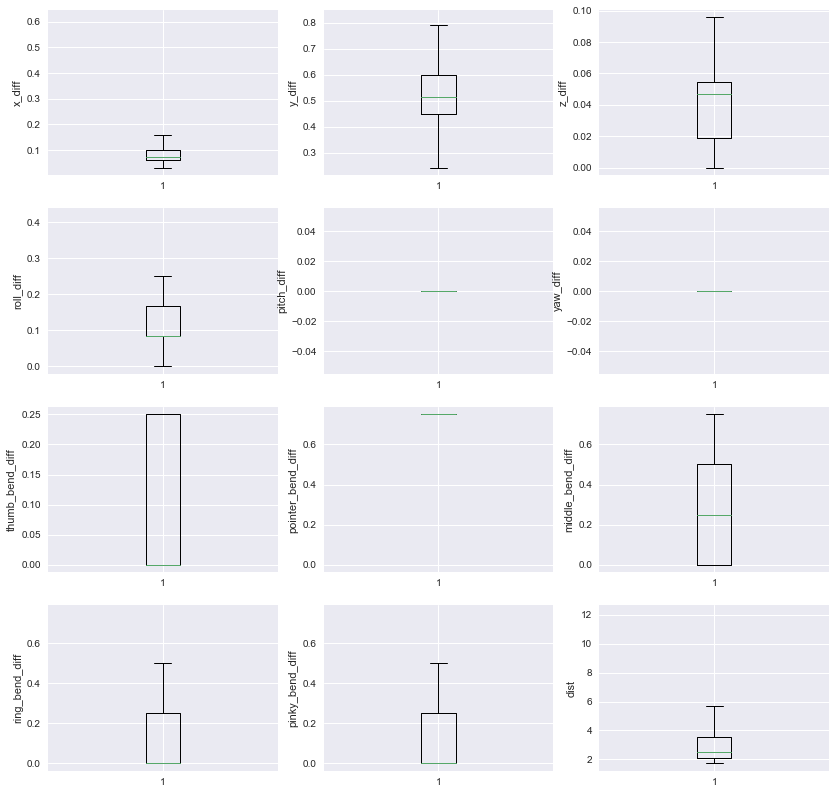

In [155]:
plot_diffs(what_features,'x_diff','y_diff','z_diff','roll_diff','pitch_diff','yaw_diff', \
           'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff','pinky_bend_diff', 'dist')

## WHEN

In [7]:
when = read_all_files("when")

when_features = concat_diffs(when,'x','y','z',
  'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
when_features = concat_beg_end(when_features,when,'x','y','z', \
                           'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
when_features = add_dist(when_features, when)
when_features['is_what']=0
when_features.head(5)
#plot_diffs(when_features,'x_diff','y_diff','z_diff','roll_diff','pitch_diff','yaw_diff', \
#          'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff','pinky_bend_diff', 'dist')

,signr_sess_test,x_25,x_75,x_diff,y_25,y_75,y_diff,z_25,z_75,z_diff,pitch_25,pitch_75,pitch_diff,roll_25,roll_75,roll_diff,yaw_25,yaw_75,yaw_diff,thumb_bend_25,thumb_bend_75,thumb_bend_diff,pointer_bend_25,pointer_bend_75,pointer_bend_diff,...,pointer_bend_last_field,pointer_bend_middle_field,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_first_field,middle_bend_last_field,middle_bend_middle_field,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_first_field,ring_bend_last_field,ring_bend_middle_field,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_first_field,pinky_bend_last_field,pinky_bend_middle_field,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,dist,is_what
0,adam1-1,-0.326172,-0.007812,0.318360,0.029297,0.697265,0.667968,-0.007812,0.015625,0.023437,-1.0,-1.0,0.0,0.083333,0.250000,0.166667,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.75,0.75,...,0.75,0.00,0.0,0.75,-0.75,0.25,0.50,0.00,0.25,0.50,-0.25,0.50,0.75,0.00,0.25,0.75,-0.50,0.50,0.75,0.00,0.25,0.75,-0.50,2.029977,0
1,adam2-1,-0.197265,0.009765,0.207031,0.015625,0.761719,0.746094,0.000000,0.023438,0.023438,-1.0,-1.0,0.0,0.083333,0.333333,0.250000,-1.0,-1.0,0.0,0.5,0.50,0.00,0.0,0.75,0.75,...,0.75,0.00,0.0,0.75,-0.75,0.50,0.75,0.00,0.25,0.75,-0.50,0.50,0.75,0.00,0.25,0.75,-0.50,0.50,0.75,0.00,0.25,0.75,-0.50,2.649872,0
2,adam2-5,-0.464844,-0.031250,0.433594,0.000000,0.722656,0.722656,-0.007812,0.000000,0.007812,-1.0,-1.0,0.0,0.083333,0.333333,0.250000,-1.0,-1.0,0.0,0.5,0.50,0.00,0.0,0.75,0.75,...,0.75,0.00,0.0,0.75,-0.75,0.75,0.75,0.25,0.00,0.50,-0.50,0.75,0.75,0.00,0.00,0.75,-0.75,0.75,0.75,0.00,0.00,0.75,-0.75,2.641913,0
3,andrew1-0,-0.185547,0.015625,0.201172,0.015625,0.585938,0.570313,0.000000,0.070312,0.070312,-1.0,-1.0,0.0,0.000000,0.333333,0.333333,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.75,0.75,...,0.75,0.00,0.0,0.75,-0.75,0.75,0.75,0.00,0.00,0.75,-0.75,0.75,0.50,0.00,-0.25,0.50,-0.75,0.75,0.50,0.00,-0.25,0.50,-0.75,2.320228,0
4,andrew2-0,-0.162110,0.000000,0.162110,-0.039062,0.316406,0.355468,0.000000,0.007812,0.007812,-1.0,-1.0,0.0,0.083333,0.083333,0.000000,-1.0,-1.0,0.0,0.0,0.25,0.25,0.0,0.75,0.75,...,0.75,0.75,0.0,0.00,0.00,0.25,0.75,0.75,0.50,0.00,0.50,0.00,0.75,0.75,0.75,0.00,0.75,0.00,0.75,0.75,0.75,0.00,0.75,2.359726,0


## WHERE

In [8]:
where = read_all_files("where")
where_features = concat_diffs(where,'x','y','z',
  'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
where_features = concat_beg_end(where_features,where,'x','y','z', \
                           'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
where_features = add_dist(where_features, where)
where_features['is_what']=0
where_features.head(5)

,signr_sess_test,x_25,x_75,x_diff,y_25,y_75,y_diff,z_25,z_75,z_diff,pitch_25,pitch_75,pitch_diff,roll_25,roll_75,roll_diff,yaw_25,yaw_75,yaw_diff,thumb_bend_25,thumb_bend_75,thumb_bend_diff,pointer_bend_25,pointer_bend_75,pointer_bend_diff,...,pointer_bend_last_field,pointer_bend_middle_field,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_first_field,middle_bend_last_field,middle_bend_middle_field,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_first_field,ring_bend_last_field,ring_bend_middle_field,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_first_field,pinky_bend_last_field,pinky_bend_middle_field,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,dist,is_what
0,adam1-1,-0.078125,-0.001953,0.076172,0.007812,0.140625,0.132813,-0.031250,0.0,0.031250,-1.0,-1.0,0.0,0.083333,0.333333,0.250000,-1.0,-1.0,0.0,0.0,0.0000,0.0000,0.0,0.75,0.75,...,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,1.402963,0
1,adam2-0,0.007812,0.031250,0.023438,-0.007812,0.093750,0.101562,-0.023438,0.0,0.023438,-1.0,-1.0,0.0,0.000000,0.333333,0.333333,-1.0,-1.0,0.0,0.5,0.5000,0.0000,0.0,0.75,0.75,...,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.25,0.75,0.0,0.5,0.75,-0.25,0.25,0.75,0.0,0.5,0.75,-0.25,1.381627,0
2,adam2-3,-0.039062,0.021485,0.060547,0.023438,0.179688,0.156250,-0.037109,0.0,0.037109,-1.0,-1.0,0.0,0.020833,0.395834,0.375000,-1.0,-1.0,0.0,0.5,0.5000,0.0000,0.0,0.75,0.75,...,0.75,0.0,0.0,0.75,-0.75,0.50,0.75,0.0,0.25,0.75,-0.50,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,1.601010,0
3,andrew1-0,-0.062500,0.000000,0.062500,0.000000,0.046875,0.046875,-0.039062,0.0,0.039062,-1.0,-1.0,0.0,0.083333,0.416667,0.333334,-1.0,-1.0,0.0,0.0,0.0000,0.0000,0.0,0.75,0.75,...,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,2.406588,0
4,andrew2-0,-0.113281,0.007812,0.121093,0.000000,0.031250,0.031250,-0.062500,0.0,0.062500,-1.0,-1.0,0.0,0.000000,0.416667,0.416667,-1.0,-1.0,0.0,0.0,0.0625,0.0625,0.0,0.75,0.75,...,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,2.053828,0


In [196]:
len(what_features)

70

## WHICH

In [9]:
which = read_all_files("which")
which_features = concat_diffs(which,'x','y','z',
  'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
which_features = concat_beg_end(which_features,where,'x','y','z', \
                           'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
which_features = add_dist(which_features, where)
which_features['is_what']=0
which_features.head(5)


,signr_sess_test,x_25,x_75,x_diff,y_25,y_75,y_diff,z_25,z_75,z_diff,pitch_25,pitch_75,pitch_diff,roll_25,roll_75,roll_diff,yaw_25,yaw_75,yaw_diff,thumb_bend_25,thumb_bend_75,thumb_bend_diff,pointer_bend_25,pointer_bend_75,pointer_bend_diff,...,pointer_bend_last_field,pointer_bend_middle_field,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_first_field,middle_bend_last_field,middle_bend_middle_field,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_first_field,ring_bend_last_field,ring_bend_middle_field,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_first_field,pinky_bend_last_field,pinky_bend_middle_field,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,dist,is_what
0,adam1-1,-0.101562,0.031250,0.132812,0.023438,0.265625,0.242187,-0.070312,0.007812,0.078124,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.00,0.00,0.0,0.75,0.7500,0.0000,...,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,1.402963,0
1,adam2-0,-0.222657,-0.085938,0.136719,0.054688,0.339844,0.285156,-0.062500,0.000000,0.062500,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.25,0.25,0.0,0.75,0.7500,0.0000,...,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.25,0.75,0.0,0.5,0.75,-0.25,0.25,0.75,0.0,0.5,0.75,-0.25,1.381627,0
2,adam2-3,-0.050781,0.025391,0.076172,0.000000,0.361328,0.361328,-0.064453,0.000000,0.064453,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.25,0.25,0.0,0.25,0.5625,0.3125,...,0.75,0.0,0.0,0.75,-0.75,0.50,0.75,0.0,0.25,0.75,-0.50,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,1.601010,0
3,andrew1-0,-0.085938,0.000000,0.085938,0.000000,0.304688,0.304688,-0.023438,0.000000,0.023438,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.00,0.00,0.0,0.75,0.7500,0.0000,...,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,2.406588,0
4,andrew2-0,-0.039062,0.015625,0.054687,0.000000,0.281250,0.281250,0.000000,0.007812,0.007812,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.00,0.00,0.0,0.50,0.7500,0.2500,...,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,2.053828,0


## WHO

In [10]:
who = read_all_files("who")
who_features = concat_diffs(who,'x','y','z',
  'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
who_features = concat_beg_end(who_features,who,'x','y','z', \
                           'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
who_features = add_dist(who_features, who)
who_features['is_what']=0
who_features.head(5)


,signr_sess_test,x_25,x_75,x_diff,y_25,y_75,y_diff,z_25,z_75,z_diff,pitch_25,pitch_75,pitch_diff,roll_25,roll_75,roll_diff,yaw_25,yaw_75,yaw_diff,thumb_bend_25,thumb_bend_75,thumb_bend_diff,pointer_bend_25,pointer_bend_75,pointer_bend_diff,...,pointer_bend_last_field,pointer_bend_middle_field,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_first_field,middle_bend_last_field,middle_bend_middle_field,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_first_field,ring_bend_last_field,ring_bend_middle_field,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_first_field,pinky_bend_last_field,pinky_bend_middle_field,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,dist,is_what
0,adam2-0,-0.179688,-0.062500,0.117188,0.046875,0.609375,0.562500,-0.039062,-0.007812,0.031250,-1.0,-1.0,0.0,0.083333,0.333333,0.250000,-1.0,-1.0,0.0,0.5,0.5,0.0,0.0,0.75,0.75,...,0.75,0.0,0.25,0.75,-0.50,0.75,0.50,0.0,-0.25,0.50,-0.75,0.75,0.75,0.75,0.00,0.00,0.00,0.75,0.75,0.75,0.00,0.00,0.00,2.596516,0
1,adam2-1,-0.226562,-0.076172,0.150390,0.054688,0.628906,0.574218,-0.023438,0.000000,0.023438,-1.0,-1.0,0.0,0.083333,0.354166,0.270834,-1.0,-1.0,0.0,0.5,0.5,0.0,0.0,0.75,0.75,...,0.75,0.0,0.00,0.75,-0.75,0.50,0.50,0.5,0.00,0.00,0.00,0.75,0.50,0.75,-0.25,-0.25,0.00,0.75,0.50,0.75,-0.25,-0.25,0.00,2.531040,0
2,adam2-2,-0.181640,0.000000,0.181640,0.033203,0.638672,0.605469,-0.037109,0.000000,0.037109,-1.0,-1.0,0.0,0.083333,0.333333,0.250000,-1.0,-1.0,0.0,0.5,0.5,0.0,0.0,0.75,0.75,...,0.50,0.0,0.00,0.50,-0.50,0.50,0.25,0.5,-0.25,-0.25,0.00,0.50,0.50,0.75,0.00,-0.25,0.25,0.50,0.50,0.75,0.00,-0.25,0.25,3.111175,0
3,adam2-3,-0.158203,0.015625,0.173828,0.068359,0.658203,0.589844,-0.031250,0.000000,0.031250,-1.0,-1.0,0.0,0.083333,0.333333,0.250000,-1.0,-1.0,0.0,0.5,0.5,0.0,0.0,0.75,0.75,...,0.50,0.0,0.00,0.50,-0.50,0.25,0.25,0.5,0.00,-0.25,0.25,0.75,0.50,0.75,-0.25,-0.25,0.00,0.75,0.50,0.75,-0.25,-0.25,0.00,2.570996,0
4,andrew2-0,0.007812,0.062500,0.054688,-0.023438,-0.007812,0.015626,0.000000,0.000000,0.000000,-1.0,-1.0,0.0,0.000000,0.083333,0.083333,-1.0,-1.0,0.0,0.0,0.0,0.0,0.5,0.75,0.25,...,0.00,0.5,-0.75,-0.50,-0.25,0.25,0.00,0.0,-0.25,0.00,-0.25,0.75,0.00,0.75,-0.75,-0.75,0.00,0.75,0.00,0.75,-0.75,-0.75,0.00,3.776907,0


## WHY

In [11]:
why = read_all_files("why")
why_features = concat_diffs(why,'x','y','z',
  'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
why_features = concat_beg_end(why_features,why,'x','y','z', \
                           'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
why_features = add_dist(why_features, why)
why_features['is_what']=0
why_features.head(5)


,signr_sess_test,x_25,x_75,x_diff,y_25,y_75,y_diff,z_25,z_75,z_diff,pitch_25,pitch_75,pitch_diff,roll_25,roll_75,roll_diff,yaw_25,yaw_75,yaw_diff,thumb_bend_25,thumb_bend_75,thumb_bend_diff,pointer_bend_25,pointer_bend_75,pointer_bend_diff,...,pointer_bend_last_field,pointer_bend_middle_field,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_first_field,middle_bend_last_field,middle_bend_middle_field,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_first_field,ring_bend_last_field,ring_bend_middle_field,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_first_field,pinky_bend_last_field,pinky_bend_middle_field,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,dist,is_what
0,adam1-0,-0.353515,-0.023438,0.330077,0.054688,0.390625,0.335937,-0.039062,0.000000,0.039062,-1.0,-1.0,0.0,0.083333,0.083333,0.000000,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.75,0.75,...,0.75,0.0,0.0,0.75,-0.75,0.50,0.50,0.00,0.0,0.50,-0.50,0.50,0.50,0.50,0.0,0.00,0.00,0.50,0.50,0.50,0.0,0.00,0.00,1.668322,0
1,adam2-0,-0.382812,0.052735,0.435547,0.101562,0.462890,0.361328,0.007812,0.060547,0.052735,-1.0,-1.0,0.0,0.000000,0.229167,0.229167,-1.0,-1.0,0.0,0.5,0.50,0.00,0.0,0.75,0.75,...,0.50,0.0,0.5,0.50,0.00,0.25,0.25,0.00,0.0,0.25,-0.25,0.75,0.25,0.25,-0.5,0.00,-0.50,0.75,0.25,0.25,-0.5,0.00,-0.50,6.045561,0
2,adam2-3,-0.437499,0.000000,0.437499,0.085938,0.552735,0.466797,0.000000,0.037109,0.037109,-1.0,-1.0,0.0,0.000000,0.166667,0.166667,-1.0,-1.0,0.0,0.5,0.50,0.00,0.0,0.75,0.75,...,0.75,0.0,0.0,0.75,-0.75,0.25,0.25,0.00,0.0,0.25,-0.25,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2.095945,0
3,andrew1-0,-0.171875,0.000000,0.171875,0.005859,0.250000,0.244141,0.000000,0.015625,0.015625,-1.0,-1.0,0.0,0.000000,0.083333,0.083333,-1.0,-1.0,0.0,0.0,0.25,0.25,0.0,0.75,0.75,...,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.50,0.0,0.25,-0.25,0.00,0.00,0.75,0.0,-0.75,0.75,0.00,0.00,0.75,0.0,-0.75,0.75,2.432508,0
4,andrew2-0,-0.257812,0.000000,0.257812,0.000000,0.400391,0.400391,0.000000,0.007812,0.007812,-1.0,-1.0,0.0,0.000000,0.250000,0.250000,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.50,0.50,...,0.75,0.0,0.0,0.75,-0.75,0.50,0.50,0.25,0.0,0.25,-0.25,0.75,0.75,0.25,0.0,0.50,-0.50,0.75,0.75,0.25,0.0,0.50,-0.50,2.309182,0


# Can we distinguish between "What" and "Not What"?

In [12]:
   # try with different non-what word.  already tried when.  where
df=pd.concat([what_features,where_features]).sort_index()
df=df[['x_diff','y_diff','z_diff','roll_diff','pitch_diff','yaw_diff', \
         'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff','pinky_bend_diff', \
       'x_last_first', 'x_last_middle', 'x_middle_first', \
       'y_last_first', 'y_last_middle', 'y_middle_first', \
       'z_last_first', 'z_last_middle', 'z_middle_first', \
       'roll_last_first', 'roll_last_middle', 'roll_middle_first', \
       'pitch_last_first', 'pitch_last_middle', 'pitch_middle_first', \
       'yaw_last_first', 'yaw_last_middle', 'yaw_middle_first', \
       'thumb_bend_last_first', 'thumb_bend_last_middle', 'thumb_bend_middle_first', \
       'pointer_bend_last_first', 'pointer_bend_last_middle', 'pointer_bend_middle_first', \
       'middle_bend_last_first', 'middle_bend_last_middle', 'middle_bend_middle_first', \
       'ring_bend_last_first', 'ring_bend_last_middle', 'ring_bend_middle_first', \
       'pinky_bend_last_first', 'pinky_bend_last_middle', 'pinky_bend_middle_first', \
      'dist', \
     'is_what']]
df.is_what.value_counts()





1    35
0    33
Name: is_what, dtype: int64

In [312]:
df.columns

Index([u'signr_sess_test', u'x_25', u'x_75', u'x_diff', u'y_25', u'y_75',
       u'y_diff', u'z_25', u'z_75', u'z_diff',
       ...
       u'ring_bend_last_middle', u'ring_bend_middle_first',
       u'pinky_bend_first_field', u'pinky_bend_last_field',
       u'pinky_bend_middle_field', u'pinky_bend_last_first',
       u'pinky_bend_last_middle', u'pinky_bend_middle_first', u'dist',
       u'is_what'],
      dtype='object', length=102)

In [13]:
   # what appears 47% of the time
df.is_what.mean()

0.5147058823529411

In [14]:
   # very little correlation,  get rid of pitch_diff, yaw_diff and their first/middle/last counterparts.
    # get rid of one of ring_* vs pinky_* because they are the same.
df.corr()

,x_diff,y_diff,z_diff,roll_diff,pitch_diff,yaw_diff,thumb_bend_diff,pointer_bend_diff,middle_bend_diff,ring_bend_diff,pinky_bend_diff,x_last_first,x_last_middle,x_middle_first,y_last_first,y_last_middle,y_middle_first,z_last_first,z_last_middle,z_middle_first,roll_last_first,roll_last_middle,roll_middle_first,pitch_last_first,pitch_last_middle,pitch_middle_first,yaw_last_first,yaw_last_middle,yaw_middle_first,thumb_bend_last_first,thumb_bend_last_middle,thumb_bend_middle_first,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,dist,is_what
x_diff,1.000000,0.231112,-0.346259,-0.194949,NaN,NaN,0.067127,0.060209,0.046084,-0.140419,-0.140419,0.056170,0.480073,-0.444164,0.002701,-0.177066,0.179192,0.039525,0.094582,-0.093192,-0.065012,-0.177901,0.145627,NaN,NaN,NaN,NaN,NaN,NaN,-0.126377,-0.088512,-0.039487,-0.111905,0.011734,-0.132592,-0.081972,0.080000,-0.134180,-0.096788,0.001058,-0.084380,-0.096788,0.001058,-0.084380,0.543657,0.090704
y_diff,0.231112,1.000000,0.191008,-0.815069,NaN,NaN,0.296607,-0.069818,-0.622525,-0.618098,-0.618098,0.156862,0.099227,-0.023848,-0.109859,-0.948450,0.926139,-0.127024,-0.414768,0.421041,-0.164790,0.361224,-0.525065,NaN,NaN,NaN,NaN,NaN,NaN,0.029912,-0.378137,0.453061,0.240000,-0.043237,0.296833,0.018481,-0.549086,0.564644,-0.038937,-0.587216,0.642296,-0.038937,-0.587216,0.642296,0.548172,0.890282
z_diff,-0.346259,0.191008,1.000000,-0.105622,NaN,NaN,0.270890,0.054813,-0.281933,-0.175259,-0.175259,0.074524,-0.047475,0.081389,-0.079509,-0.239413,0.219748,-0.131219,-0.347703,0.346355,-0.062008,0.200585,-0.268767,NaN,NaN,NaN,NaN,NaN,NaN,0.039006,-0.082000,0.133731,-0.098893,-0.047150,-0.077496,0.051894,-0.274000,0.309705,0.094115,-0.158770,0.263574,0.094115,-0.158770,0.263574,-0.083540,0.326003
roll_diff,-0.194949,-0.815069,-0.105622,1.000000,NaN,NaN,-0.107200,0.076966,0.645549,0.567834,0.567834,-0.108770,-0.045775,-0.006031,0.095690,0.804057,-0.784450,0.051395,0.344458,-0.364117,0.186067,-0.454340,0.644028,NaN,NaN,NaN,NaN,NaN,NaN,-0.011643,0.297734,-0.343733,-0.217456,0.008384,-0.247710,0.016483,0.600593,-0.593579,0.078161,0.608206,-0.632748,0.078161,0.608206,-0.632748,-0.317117,-0.829529
pitch_diff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yaw_diff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thumb_bend_diff,0.067127,0.296607,0.270890,-0.107200,NaN,NaN,1.000000,0.104086,-0.223824,-0.295089,-0.295089,0.146044,0.174146,-0.102327,0.080261,-0.252842,0.276585,-0.099583,-0.222762,0.217754,-0.173980,-0.090465,-0.034855,NaN,NaN,NaN,NaN,NaN,NaN,0.015904,-0.270161,0.317726,-0.090304,0.045666,-0.131967,0.061518,-0.162430,0.203735,-0.026310,-0.223895,0.235046,-0.026310,-0.223895,0.235046,0.319312,0.296484
pointer_bend_diff,0.060209,-0.069818,0.054813,0.076966,NaN,NaN,0.104086,1.000000,0.159739,0.232675,0.232675,-0.077370,0.135180,-0.168666,0.116140,0.126519,-0.096037,-0.030879,-0.021086,0.014881,0.081322,0.051728,0.005895,NaN,NaN,NaN,NaN,NaN,NaN,-0.087042,-0.004881,-0.089549,-0.337915,0.339824,-0.610363,0.146667,0.185755,-0.090885,0.071136,0.181554,-0.147806,0.071136,0.181554,-0.147806,0.074021,-0.044316
middle_bend_diff,0.046084,-0.622525,-0.281933,0.645549,NaN,NaN,-0.223824,0.159739,1.000000,0.740302,0.740302,-0.127862,0.162096,-0.218665,-0.011423,0.680229,-0.688678,0.148637,0.427333,-0.429051,0.061599,-0.384947,0.471434,NaN,NaN,NaN,NaN,NaN,NaN,-0.121687,0.271021,-0.434107,-0.302981,0.054137,-0.374420,-0.012034,0.895439,-0.908955,0.131266,0.749474,-0.749686,0.131266,0.749474,-0.749686,-0.093785,-0.763208
ring

In [14]:
df.isnull().sum().sum()

0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112ef1f10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11368bc90>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x116bd8050>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117c1a050>, ...,
       ..., 
        <matplotlib.axes._subplots.AxesSubplot object at 0x1359bce50>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x136a57050>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x137ad6450>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1388f6c90>]], dtype=object)

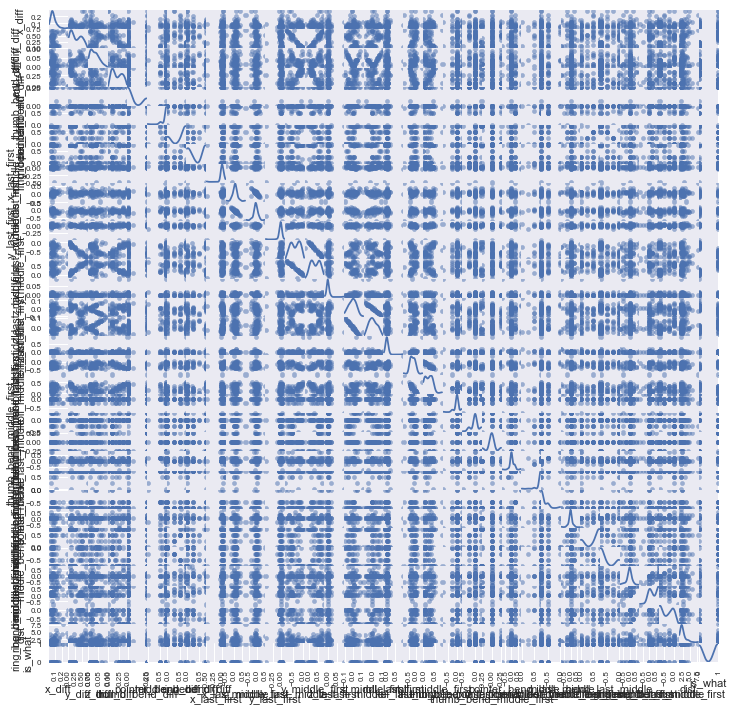

In [15]:
    # took out pitch_diff and yaw_diff because always 0.  took out pinky_bend_diff because same as ring_bend_diff
pd.tools.plotting.scatter_matrix(
    df[ ['x_diff','y_diff','z_diff', 'roll_diff',\
         #'pitch_diff','yaw_diff', \
           'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff', \
           #,'pinky_bend_diff', \
       'x_last_first', 'x_last_middle', 'x_middle_first', \
       'y_last_first', 'y_last_middle', 'y_middle_first', \
       'z_last_first', 'z_last_middle', 'z_middle_first', \
       'roll_last_first', 'roll_last_middle', 'roll_middle_first', \
       'thumb_bend_last_first', 'thumb_bend_last_middle', 'thumb_bend_middle_first', \
       'pointer_bend_last_first', 'pointer_bend_last_middle', 'pointer_bend_middle_first', \
       'middle_bend_last_first', 'middle_bend_last_middle', 'middle_bend_middle_first', \
       'ring_bend_last_first', 'ring_bend_last_middle', 'ring_bend_middle_first', \
         'dist', \
      'is_what'] ],
    diagonal = 'kde', s = 75, figsize = (12, 12))

In [16]:
df.groupby('is_what').mean()

,x_diff,y_diff,z_diff,roll_diff,pitch_diff,yaw_diff,thumb_bend_diff,pointer_bend_diff,middle_bend_diff,ring_bend_diff,pinky_bend_diff,x_last_first,x_last_middle,x_middle_first,y_last_first,y_last_middle,y_middle_first,z_last_first,z_last_middle,z_middle_first,roll_last_first,roll_last_middle,roll_middle_first,pitch_last_first,pitch_last_middle,pitch_middle_first,yaw_last_first,yaw_last_middle,yaw_middle_first,thumb_bend_last_first,thumb_bend_last_middle,thumb_bend_middle_first,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,dist
is_what,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.083688,0.130327,0.025568,0.320076,0.0,0.0,0.039773,0.712121,0.704545,0.647727,0.647727,-0.008286,0.071733,-0.080019,-0.001184,-0.150568,0.149384,0.004498,0.022254,-0.017756,0.030303,-0.305556,0.335859,0.0,0.0,0.0,0.0,0.0,0.0,-0.015152,0.053030,-0.068182,0.015152,0.719697,-0.704545,-0.022727,0.681818,-0.704545,-0.007576,0.636364,-0.643939,-0.007576,0.636364,-0.643939,2.083640
1,0.092522,0.512612,0.040681,0.101786,0.0,0.0,0.107143,0.701786,0.214286,0.151786,0.151786,0.022991,0.069420,-0.046429,-0.006473,-0.589063,0.582589,0.000670,-0.032366,0.033036,0.004762,-0.145238,0.150000,0.0,0.0,0.0,0.0,0.0,0.0,0.007143,-0.064286,0.071429,0.085714,0.714286,-0.628571,0.007143,0.250000,-0.242857,-0.042857,0.100000,-0.142857,-0.042857,0.100000,-0.142857,2.929855


## Logistic Regression with Grid Search

In [17]:
X = df[['x_diff','y_diff','z_diff', 'roll_diff',\
         'pitch_diff','yaw_diff', \
           'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff', \
           'pinky_bend_diff', \
       'x_last_first', 'x_last_middle', 'x_middle_first', \
       'y_last_first', 'y_last_middle', 'y_middle_first', \
       'z_last_first', 'z_last_middle', 'z_middle_first', \
       'roll_last_first', 'roll_last_middle', 'roll_middle_first', \
       'thumb_bend_last_first', 'thumb_bend_last_middle', 'thumb_bend_middle_first', \
       'pointer_bend_last_first', 'pointer_bend_last_middle', 'pointer_bend_middle_first', \
       'middle_bend_last_first', 'middle_bend_last_middle', 'middle_bend_middle_first', \
       'ring_bend_last_first', 'ring_bend_last_middle', 'ring_bend_middle_first', \
         'dist' ]]
Y = df['is_what']

   # normalization and grid search
scaler = preprocessing.MinMaxScaler().fit(X)

X = pd.DataFrame(scaler.transform(X), columns = X.columns)

gs = model_selection.GridSearchCV(
    estimator = linear_model.LogisticRegression(),
    param_grid = {'C': np.logspace(-10, 10, 21), 'penalty': ['l1']},
    cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 3)
)

gs.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1'], 'C': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [18]:
gs.best_params_

{'C': 1.0, 'penalty': 'l1'}

In [19]:
gs.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
model = gs.best_estimator_.fit(X, Y)
print model.intercept_
print zip(X.columns, model.coef_[0])

[ 0.]
[('x_diff', 0.0), ('y_diff', 4.6149045847332832), ('z_diff', 0.0), ('roll_diff', -2.4287999991371749), ('pitch_diff', 0.0), ('yaw_diff', 0.0), ('thumb_bend_diff', 0.0), ('pointer_bend_diff', 0.0), ('middle_bend_diff', -0.45199716509465998), ('ring_bend_diff', -0.33336837731260688), ('pinky_bend_diff', -1.2362391341806904), ('x_last_first', 0.0), ('x_last_middle', 0.0), ('x_middle_first', 0.0), ('y_last_first', 0.0), ('y_last_middle', 0.0), ('y_middle_first', 0.0), ('z_last_first', 0.0), ('z_last_middle', 0.0), ('z_middle_first', 0.0), ('roll_last_first', 0.0), ('roll_last_middle', 0.0), ('roll_middle_first', 0.0), ('thumb_bend_last_first', 0.0), ('thumb_bend_last_middle', 0.0), ('thumb_bend_middle_first', 0.0), ('pointer_bend_last_first', 0.0), ('pointer_bend_last_middle', 0.0), ('pointer_bend_middle_first', 0.0), ('middle_bend_last_first', 0.0), ('middle_bend_last_middle', 0.0), ('middle_bend_middle_first', 1.2690784207034096), ('ring_bend_last_first', 0.0), ('ring_bend_last_mid

In [21]:
from sklearn import model_selection
   # 0.98571428571428577 if take all variables
model_selection.cross_val_score(model, X , Y, cv= 5).mean()

0.98571428571428577

In [22]:
c_hat = model.predict(X)

pd.crosstab(c_hat,
    Y,
    rownames = ['Hypothesized Class'],
    colnames = ['True Class']) 

True Class,0,1
Hypothesized Class,,
0,33,0
1,0,35


## Random Forest

In [23]:
model = ensemble.RandomForestClassifier(n_estimators = 1000,
        max_features = 4,
        min_samples_leaf = 5,
        oob_score = True,
        random_state = 0).\
    fit(X, Y)

In [25]:
   # this is worse than the Logistic Regression score
model.oob_score_

0.98529411764705888

In [26]:
model_selection.cross_val_score(model, X, Y, cv = 10).mean()

0.98750000000000004

In [27]:
c_hat = model.predict(X)

pd.crosstab(c_hat,
    Y,
    rownames = ['Hypothesized Class'],
    colnames = ['True Class']) 

True Class,0,1
Hypothesized Class,,
0,33,0
1,0,35


### Random Forest Grid Search

In [28]:
from sklearn.model_selection import GridSearchCV

# build a classifier
clf = ensemble.RandomForestClassifier(n_estimators=20)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 4, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True],
              "criterion": ["gini", "entropy"],
              "oob_score": [True]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, \
                              cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 3))
grid_search.fit(X, Y)

/Users/seanmcghee/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/seanmcghee/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'oob_score': [True], 'bootstrap': [True], 'min_samples_leaf': [1, 3, 10], 'min_samples_split': [2, 4, 10], 'criterion': ['gini', 'entropy'], 'max_features': [1, 3, 10], 'max_depth': [3, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [30]:
grid_search.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'oob_score': True}

In [31]:
model = grid_search.best_estimator_.fit(X, Y)
model.oob_score_

0.92647058823529416

In [32]:
model_selection.cross_val_score(model, X , Y, cv= 5).mean()

0.95494505494505511

In [33]:
c_hat = model.predict(X)

pd.crosstab(c_hat,
    Y,
    rownames = ['Hypothesized Class'],
    colnames = ['True Class']) 

True Class,0,1
Hypothesized Class,,
0,33,0
1,0,35
